# Mod 4 Project - Zillow Housing Data Analysis
## The objective of our analysis is to predict the 5 "best" zipcodes for real estate investment


# Load the Data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import itertools
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
import pmdarima as pm
import sys, os
import time

In [5]:
df = pd.read_csv('zillow_data.csv')

df.drop('RegionID',axis=1,inplace=True)

df.head()

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Data Preprocessing

### Converting column names to datetime format

In [6]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

# EDA and Visualization

In [7]:
font = {'family' : 'normal',
#'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

### Visualizing the normalized prices for the first 200 data points

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


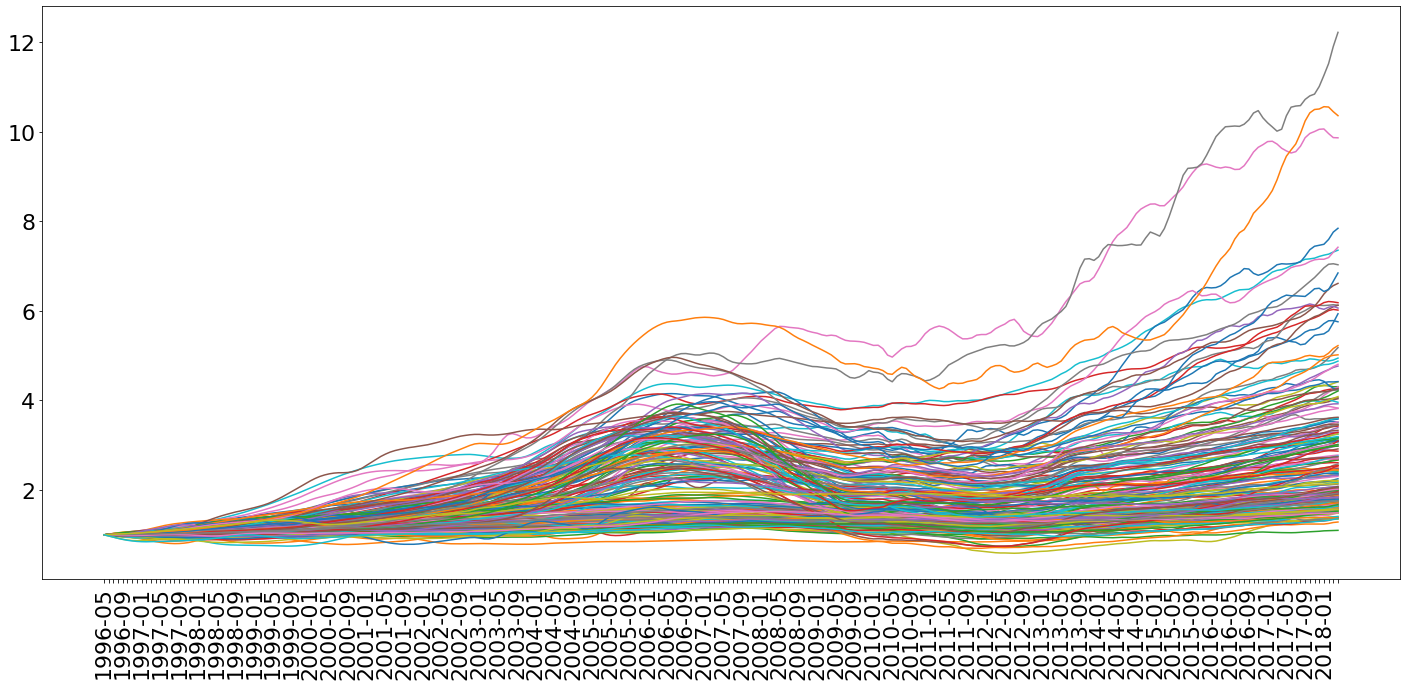

In [8]:
fig, ax = plt.subplots(figsize=(20,10))

plt.xticks(rotation='vertical')
for i in range(200):
    plt.plot(df.columns[7:],df.iloc[i][7:]/df.iloc[i][7])
    every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.tight_layout()
plt.savefig('Figures/roi_200.png')


### Plotting roi distributions assuming different starting dates

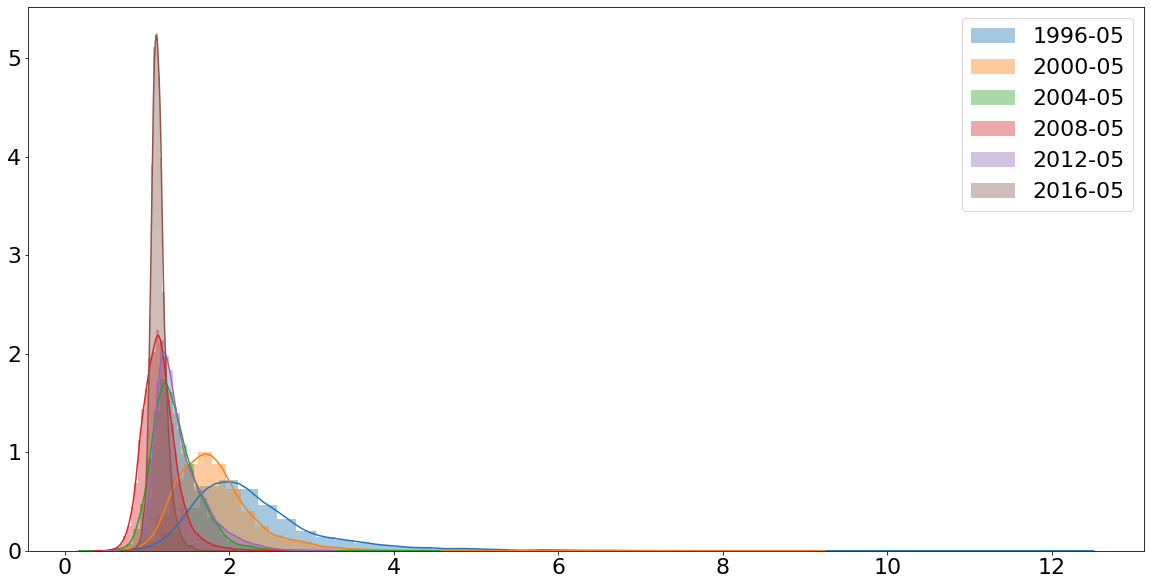

In [9]:
plt.figure(figsize=(20,10))
for i in range(7,df.shape[1]-1,48):
    roi = (df[df.columns[-1]]/df[df.columns[i]]).dropna()
    sns.distplot(roi,label = df.columns[i])
plt.legend()

In [10]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [11]:
average_ts = melt_data(df)

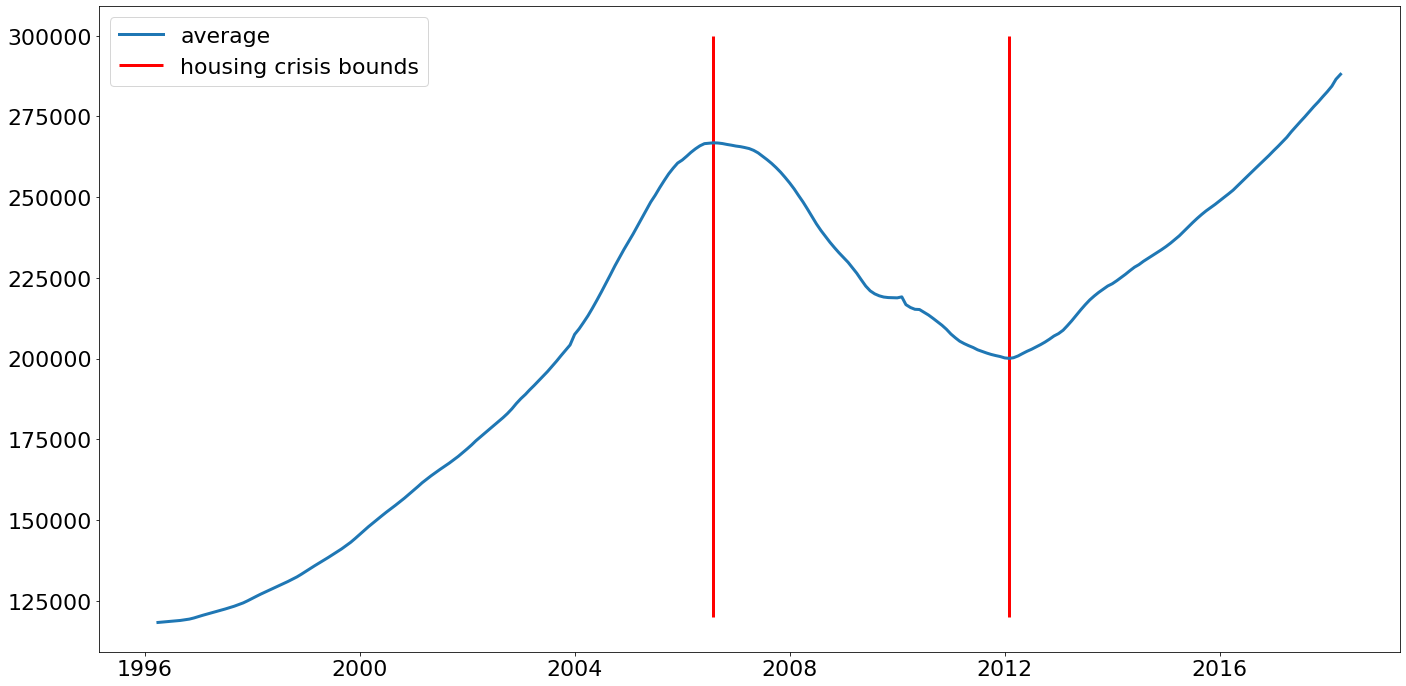

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(average_ts,label = 'average',linewidth=3);
plt.vlines('2006-08',ymin=120000,ymax=300000,label='housing crisis bounds',color='r',linewidth=3)
plt.vlines('2012-02',ymin=120000,ymax=300000,color='r',linewidth=3)
plt.legend()
plt.tight_layout()
plt.savefig('Figures/average.png')

### Naive estimates

#### Calculating starting from April 1996

In [13]:
approx_roi_total = []
for i in range(df.shape[0]):
    prices = df.iloc[i][6:].dropna()
    approx_roi_total.append(np.log(prices[-1]/prices[0])/len(prices))
df_roi_total = df.copy()
df_roi_total['roi_monthly'] = approx_roi_total

df_roi_total = (df_roi_total.sort_values(by='roi_monthly',ascending=False))[['RegionName','City','State','roi_monthly']]
df_roi_total.head()

,RegionName,City,State,roi_monthly
13409,27980,Hertford,NC,0.020954
842,30032,Candler-Mcafee,GA,0.020001
7302,80216,Denver,CO,0.016699
1998,89030,North Las Vegas,NV,0.015354
4712,94621,Oakland,CA,0.015100


#### Calculating starting from Feb 2012

In [14]:
approx_roi_2012 = []
for i in range(df.shape[0]):
    prices = df.iloc[i][196:].dropna()
    approx_roi_2012.append(np.log(prices[-1]/prices[0])/len(prices))
df_roi_2012 = df.copy()
df_roi_2012['roi_monthly'] = approx_roi_2012

df_roi_2012 = (df_roi_2012.sort_values(by='roi_monthly',ascending=False))[['RegionName','City','State','roi_monthly']]
df_roi_2012.head()

,RegionName,City,State,roi_monthly
13409,27980,Hertford,NC,0.020954
842,30032,Candler-Mcafee,GA,0.020001
7302,80216,Denver,CO,0.016699
1946,85035,Phoenix,AZ,0.016276
1998,89030,North Las Vegas,NV,0.015354


#### Note that 4 of the first 5 answers are common. This is because those 4 zipcodes only have data well after the year 2012. These might not be reliable since these are relatively new data sets. So lets get rid of all the zipcodes which don't have data starting from 1996

In [14]:
approx_roi_2012_nona = []
df_no_na = df.dropna()
for i in range(df_no_na.shape[0]):
    prices = df_no_na.iloc[i][196:].dropna()
    approx_roi_2012_nona.append(np.log(prices[-1]/prices[0])/len(prices))
df_roi_2012_nona = df_no_na.copy()
df_roi_2012_nona['roi_monthly'] = approx_roi_2012_nona

df_roi_2012_nona = (df_roi_2012_nona.sort_values(by='roi_monthly',ascending=False))[['RegionName','City','State','roi_monthly']]
df_roi_2012_nona.head()

,RegionName,City,State,roi_monthly
1853,94804,Richmond,CA,0.015304
474,85008,Phoenix,AZ,0.015298
1477,94601,Oakland,CA,0.015188
1239,94590,Vallejo,CA,0.015110
2627,33460,Lake Worth,FL,0.015037


In [212]:
approx_roi_2012_nona = []
df_no_na = df.dropna()
df_no_na = df_no_na.iloc[0:1000]
for i in range(1000):
    prices = df_no_na.iloc[i][196:].dropna()
    approx_roi_2012_nona.append(np.log(prices[-1]/prices[0])/len(prices))
df_roi_2012_nona = df_no_na.copy()
df_roi_2012_nona['roi_monthly'] = approx_roi_2012_nona

df_roi_2012_nona = (df_roi_2012_nona.sort_values(by='roi_monthly',ascending=False))[['RegionName','City','State','roi_monthly']]
df_roi_2012_nona.head()

,RegionName,City,State,roi_monthly
474,85008,Phoenix,AZ,0.015298
815,89115,Las Vegas,NV,0.014483
433,89110,Las Vegas,NV,0.014195
907,33033,Homestead,FL,0.014098
475,11216,New York,NY,0.014027


# Step 5: ARIMA Modeling

## Let's first perform the ARIMA modelling on the average data set to see what insights we can glean. In order to do an ARIMA modelling we first need to make the timeries stationary

#### We will only consider the last 6 years of data, well after the recession so we are in the correct regime for our ARIMA model

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=-806.384, BIC=-792.724, Fit time=0.286 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-774.988, BIC=-770.434, Fit time=0.056 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-853.339, BIC=-844.232, Fit time=0.245 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-820.207, BIC=-811.100, Fit time=0.461 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-552.718, BIC=-550.441, Fit time=0.019 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-855.339, BIC=-848.509, Fit time=0.121 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=-853.339, BIC=-844.232, Fit time=0.230 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=-806.043, BIC=-794.659, Fit time=0.501 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-854.283, BIC=-845.176, Fit time=0.207 seconds
Fit ARIMA: order=(1, 0, 1) s

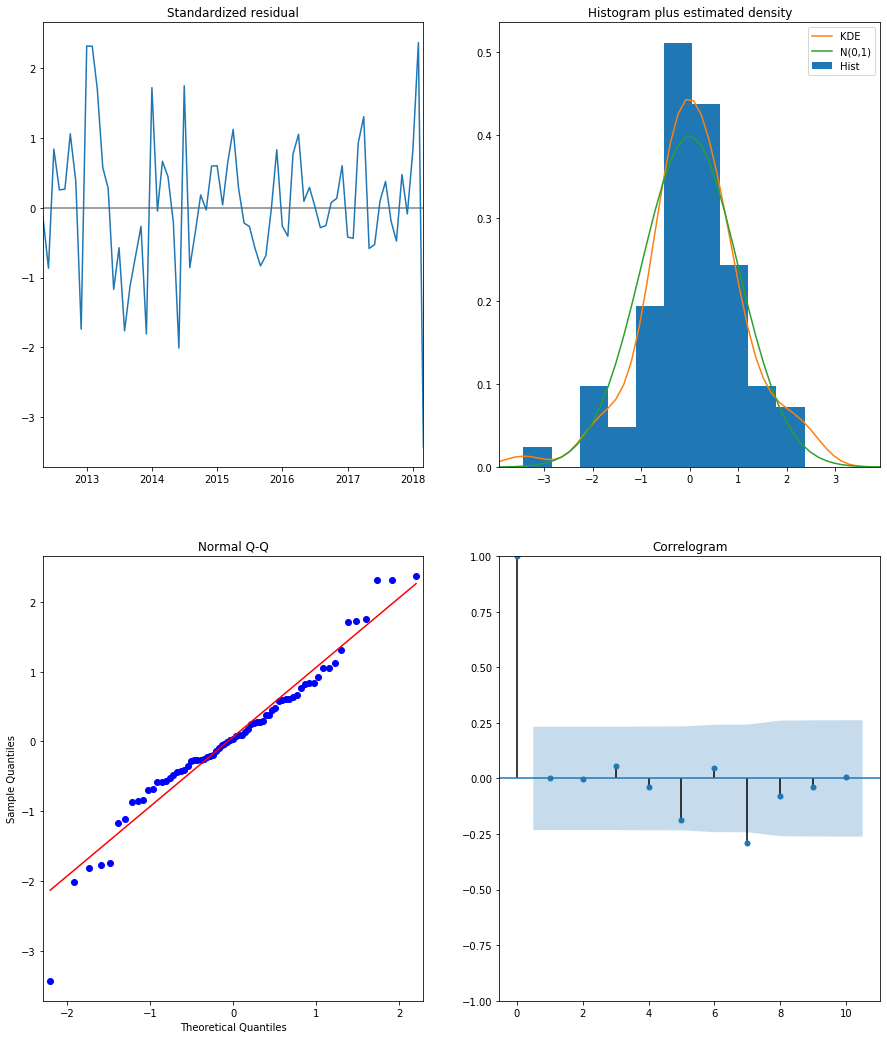

In [166]:
average_test = ((average_ts.diff(1).shift(-1)/average_ts)[-73:-1])
results = pm.auto_arima(average_test,information_criterion='aic',m=12,d=None,start_p=1,start_q=1, max_p=3, max_q=3,max_d=1,
stepwise=True,trace=True,error_action='ignore',suppress_warnings=True,method='lbfgs')
mod = sm.tsa.statespace.SARIMAX(average_test,order=results.order,
                                                seasonal_order=results.seasonal_order,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
output = mod.fit()
pred = output.get_prediction(start=pd.to_datetime('2018-03-01'),end = pd.to_datetime('2020-03-01'), dynamic=False)
pred_conf = pred.conf_int()

mean_ret = np.prod(1+pred.predicted_mean)
low_ret = np.prod(1+pred_conf.iloc[:,0])
high_ret = np.prod(1+pred_conf.iloc[:,1])
risk_free_mean = mean_ret

print('The minimum return we should expect in 2 years is ',round(mean_ret,3))
print('The ADF test p-value for stationarity is',round(sm.tsa.stattools.adfuller(average_test['value'])[1],3)) 

print(output.summary().tables[1])
output.plot_diagnostics(figsize=(15, 18))
plt.savefig('Figures/average_diagnostic.png')
plt.show()

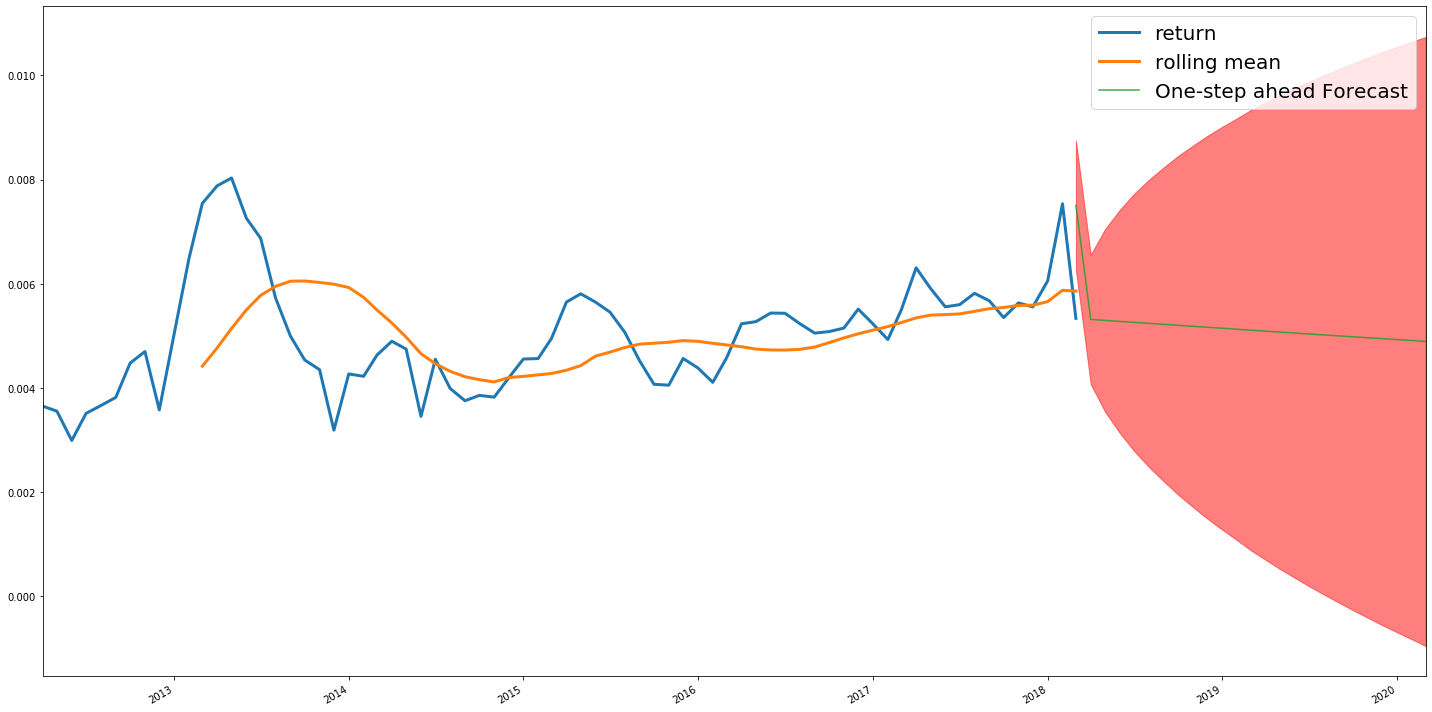

In [167]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(average_test,label = 'return',linewidth=3);
ax.plot(average_test.rolling(window=12).mean(),label = 'rolling mean',linewidth=3)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], 
                color='r', alpha=0.5)

ax.legend(loc=1,prop={'size': 20})
plt.tight_layout()
plt.savefig('Figures/average_returns.png')


### Melt the dataset

In [69]:
def melt_data_1(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted


### Now we move to perform an  (S)ARIMA analysis on the remaining zipcodes. We also drop all data that does not have data for the entire time series

In [70]:
melted_df = melt_data_1(df.dropna())

### Visually checking the stationarity of our data

Text(0, 0.5, 'Percent Change')

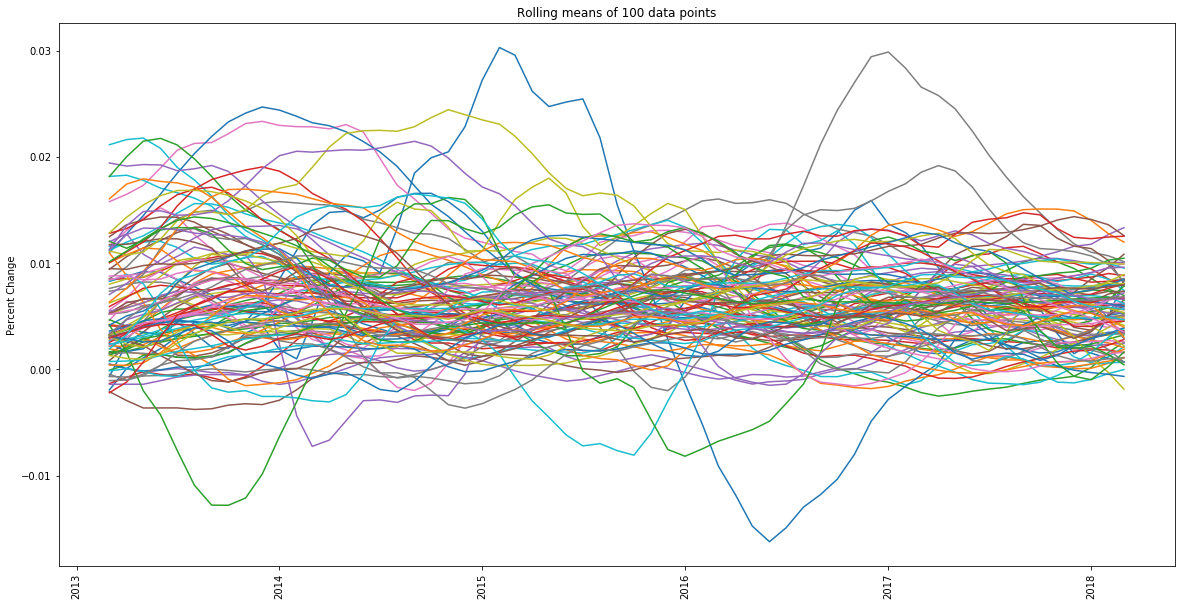

In [83]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation='vertical')
for zc in melted_df.RegionName.unique()[0:100]: 
    df_city = melted_df[melted_df.RegionName==zc][['time','value']]
    df_city.set_index('time',inplace=True)

    test = ((df_city.diff(1).shift(-1)/df_city)[-73:-1])
    plt.plot(test.rolling(window=12).mean())
plt.title('Rolling means of 100 data points')
plt.ylabel('Percent Change')
plt.savefig('Figures/rolling_100.png')

### Performing a SARIMA analysis on last 6 years of data. (p,d,q) = ([0,3],[0,1],[0,3]) and PDQ = ([0,2],[0,1],[0,2])

In [168]:
%%capture
start_time = time.time()
final_results_1000_d1 = []
for i in melted_df.RegionName.unique()[0:1000]:
    df_test = melted_df[melted_df.RegionName==i][['time','value','City']]
    city = df_test.iloc[0]['City']
    df_city = df_test[['time','value']]
    df_city.set_index('time',inplace=True)
    test = ((df_city.diff(1).shift(-1)/df_city)[-73:-1])
    results = pm.auto_arima(test,information_criterion='aic',m=12,d=None,start_p=1,start_q=1, max_p=3, max_q=3,max_d=1,
    stepwise=True,trace=True,error_action='ignore',suppress_warnings=True,method='lbfgs')
    mod = sm.tsa.statespace.SARIMAX(test,order=results.order,
                                                seasonal_order=results.seasonal_order,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
    output = mod.fit()
    pred = output.get_prediction(start=pd.to_datetime('2018-03-01'),end = pd.to_datetime('2020-03-01'), dynamic=False)
    pred_conf = pred.conf_int()

    mean_ret = np.prod(1+pred.predicted_mean)
    low_ret = np.prod(1+pred_conf.iloc[:,0])
    high_ret = np.prod(1+pred_conf.iloc[:,1])
    final_results_1000_d1.append([i,city,mean_ret,low_ret,high_ret,results.order,results.seasonal_order])


In [171]:
final = pd.DataFrame(final_results_1000_d1,columns = ['zip','City','mean_ret','low_ret','high_ret','order','seasonal_order'])
#final.to_csv('final_1000_6_d1.csv',index=False)

In [178]:
final.sort_values(['mean_ret'],ascending=False).head(10)

,zip,City,mean_ret,low_ret,high_ret,order,seasonal_order
748,97301,Salem,1.482112,0.867844,2.499384,"(0, 1, 0)","(0, 0, 0, 12)"
399,28205,Charlotte,1.478319,1.043637,2.083222,"(1, 1, 2)","(1, 0, 1, 12)"
463,85008,Phoenix,1.476268,0.772465,2.771658,"(2, 1, 0)","(0, 0, 0, 12)"
140,98012,Bothell,1.462114,1.079082,1.973469,"(0, 1, 3)","(1, 0, 1, 12)"
646,7306,Jersey City,1.433791,0.940986,2.169114,"(0, 1, 3)","(2, 0, 0, 12)"
608,7055,Passaic,1.416075,0.965163,2.065088,"(0, 1, 3)","(0, 0, 1, 12)"
461,28227,Mint Hill,1.414882,1.018917,1.955438,"(2, 1, 1)","(0, 0, 0, 12)"
310,7087,Union City,1.401571,0.842042,2.308360,"(1, 1, 3)","(1, 0, 0, 12)"
953,92260,Palm Desert,1.400555,0.901706,2.157042,"(2, 1, 1)","(0, 0, 0, 12)"
181,7002,Bayonne,1.382036,0.638252,2.918323,"(0, 1, 3)","(2, 0, 0, 12)"


### Calculating 'Sharpe Ratio'
#### $r = \frac{(mean - mean_{riskfree})}{\sigma}$

In [177]:
final = final[(final.mean_ret < 1.5) & (final.mean_ret > final.low_ret) & (final.high_ret<3.)]
final['sharpe_ratio'] = (final.mean_ret -risk_free_mean)/(final.high_ret - final.low_ret)

In [181]:
final.sort_values(['mean_ret'],ascending=False).head()

,zip,City,mean_ret,low_ret,high_ret,order,seasonal_order,sharpe_ratio
748,97301,Salem,1.482112,0.867844,2.499384,"(0, 1, 0)","(0, 0, 0, 12)",0.210677
399,28205,Charlotte,1.478319,1.043637,2.083222,"(1, 1, 2)","(1, 0, 1, 12)",0.326990
463,85008,Phoenix,1.476268,0.772465,2.771658,"(2, 1, 0)","(0, 0, 0, 12)",0.169010
140,98012,Bothell,1.462114,1.079082,1.973469,"(0, 1, 3)","(1, 0, 1, 12)",0.361958
646,7306,Jersey City,1.433791,0.940986,2.169114,"(0, 1, 3)","(2, 0, 0, 12)",0.240534


In [182]:
final.sort_values(['sharpe_ratio'],ascending=False).head()

,zip,City,mean_ret,low_ret,high_ret,order,seasonal_order,sharpe_ratio
493,37129,Murfreesboro,1.306796,1.126410,1.514709,"(0, 1, 3)","(0, 0, 1, 12)",0.433715
654,34698,Dunedin,1.367636,1.105605,1.688692,"(3, 0, 0)","(2, 0, 1, 12)",0.393169
227,37130,Murfreesboro,1.300189,1.107280,1.525099,"(0, 1, 3)","(0, 0, 0, 12)",0.387260
140,98012,Bothell,1.462114,1.079082,1.973469,"(0, 1, 3)","(1, 0, 1, 12)",0.361958
399,28205,Charlotte,1.478319,1.043637,2.083222,"(1, 1, 2)","(1, 0, 1, 12)",0.326990


## Calculating best zipcodes to invest in for last 5 years

In [194]:
%%capture
start_time = time.time()
final_results_4_1000 = []
for i in melted_df.RegionName.unique()[0:1000]:
    df_test = melted_df[melted_df.RegionName==i][['time','value','City']]
    city = df_test.iloc[0]['City']
    df_city = df_test[['time','value']]
    df_city.set_index('time',inplace=True)
    test = ((df_city.diff(1).shift(-1)/df_city)[-61:-1])
    results = pm.auto_arima(test,information_criterion='aic',m=12,d=None,start_p=1,start_q=1, max_p=3, max_q=3,max_d=1,
    stepwise=True,trace=True,error_action='ignore',suppress_warnings=True,method='lbfgs')
    mod = sm.tsa.statespace.SARIMAX(test,order=results.order,
                                                seasonal_order=results.seasonal_order,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
    output = mod.fit()
    pred = output.get_prediction(start=pd.to_datetime('2018-03-01'),end = pd.to_datetime('2020-03-01'), dynamic=False)
    pred_conf = pred.conf_int()

    mean_ret = np.prod(1+pred.predicted_mean)
    low_ret = np.prod(1+pred_conf.iloc[:,0])
    high_ret = np.prod(1+pred_conf.iloc[:,1])
    final_results_4_1000.append([i,city,mean_ret,low_ret,high_ret,results.order,results.seasonal_order])


In [196]:
final_5 = pd.DataFrame(final_results_4_1000,columns = ['zip','City','mean_ret','low_ret','high_ret','order','seasonal_order'])

In [201]:
final_5 = final_5[(final_5.mean_ret < 1.5)&(final_5.mean_ret > 0.)& (final_5.low_ret>0)]
final_5.to_csv('final_1000_5_d1.csv',index=False)

In [202]:
final_5['sharpe_ratio'] = (final_5.mean_ret -risk_free_mean)/(final_5.high_ret - final_5.low_ret)

In [203]:
final_5.sort_values('mean_ret',ascending=False).head()

,zip,City,mean_ret,low_ret,high_ret,order,seasonal_order,sharpe_ratio
140,98012,Bothell,1.496206,1.046004,2.128354,"(2, 1, 0)","(0, 0, 0, 12)",0.330597
646,7306,Jersey City,1.480128,0.341839,5.837568,"(0, 1, 1)","(0, 0, 0, 12)",0.062184
399,28205,Charlotte,1.457343,0.951248,2.214762,"(0, 1, 0)","(0, 0, 0, 12)",0.252438
158,75228,Dallas,1.433895,0.976612,2.092502,"(0, 1, 3)","(1, 0, 0, 12)",0.264821
968,33415,Greenacres,1.429407,1.106167,1.842221,"(0, 1, 3)","(0, 0, 0, 12)",0.395382


In [204]:
final_5.sort_values('sharpe_ratio',ascending=False).head()

,zip,City,mean_ret,low_ret,high_ret,order,seasonal_order,sharpe_ratio
968,33415,Greenacres,1.429407,1.106167,1.842221,"(0, 1, 3)","(0, 0, 0, 12)",0.395382
461,28227,Mint Hill,1.414591,1.090496,1.829636,"(2, 1, 0)","(0, 0, 0, 12)",0.373687
140,98012,Bothell,1.496206,1.046004,2.128354,"(2, 1, 0)","(0, 0, 0, 12)",0.330597
699,90006,Los Angeles,1.428236,1.002417,2.024577,"(1, 0, 2)","(0, 0, 1, 12)",0.283568
779,97501,Medford,1.313452,1.038353,1.657748,"(0, 0, 2)","(2, 0, 1, 12)",0.282643


## Checking consistency

In [205]:
sharpe_5_zip = final_5.sort_values('sharpe_ratio',ascending=False)['zip']
sharpe_6_zip = final.sort_values(['sharpe_ratio'],ascending=False)['zip']


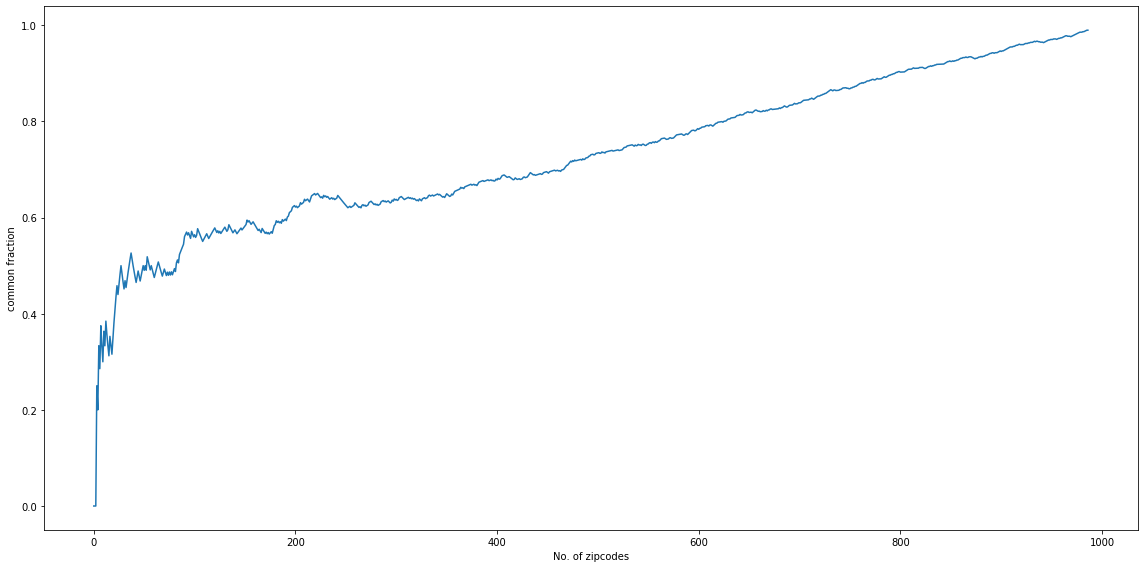

In [210]:
ratio = []
for i in range(1,len(sharpe_5_zip)):
    r = len(set(sharpe_5_zip[0:i]).intersection(set(sharpe_6_zip[0:i])))/i
    ratio.append(r)
plt.figure(figsize=(16,8))
plt.ylabel('common fraction')
plt.xlabel('No. of zipcodes')
plt.plot(ratio);
plt.tight_layout()
plt.savefig('Figures/common.png')

# Conclusion and Future work
 - We have recommended the 5 best zipcodes based on average expected returns and also on the sharpe ratio
 - We have checked the stability of our predictions
 - Need to speed up analysis and extend to all zipcodes Can be done by knowing what SARIMA solutions are favored by first 1000 zipcodes
 - Need better analysis on whether another recession is in the offing
 - Need better metric to account for zipcodes which do better than others during recession